# This Notebook aims to illustrate the book of Michael J. Best: Portfolio Optimization

In [4]:
# Here are the imports that we will need throughout the all notebook
-install requirements

import pandas as pd
import numpy as np
import os
import time
import matplotlib as plt
import sklearn
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
import threading
from ib_insync import *
import asyncio
import scipy
from mpl_toolkits.mplot3d import Axes3D
import random
import seaborn as sns

# auto reload to reload functions imported that have been changed (cf. test_functions.sphereL1 for lbda)
%load_ext autoreload
%autoreload 2
%matplotlib widget

SyntaxError: invalid syntax (3940976306.py, line 2)

Ressources utilisées pour ce notebook:

* Portfolio Optimization, Michael J. Best
* A step-by-step guide to the Black–Litterman model, Thomas Idzorek

# Test the connectivity of the IB API:

In [82]:
ib = IB()
util.startLoop()
await ib.connectAsync('127.0.0.1', 7497, clientId=3) # Don't forget to change the client ID

Error 321, reqId -1: Error validating request.-'ct' : cause - The API interface is currently in Read-Only mode.
Error 321, reqId -1: Error validating request.-'b3' : cause - The API interface is currently in Read-Only mode.
open orders request timed out
completed orders request timed out


<IB connected to 127.0.0.1:7497 clientId=3>

# Get the data and build the Portfolio:

Let P be the list of the assets in the portfolio:

In [99]:
P = {"TTE": {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'AIR': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'EXA': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'MC': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'ORA': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'GLE': {"exchange": "SMART", "currency": "EUR", "primary": "SBF"},
     'ORCL': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'BA': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'COST': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'NVDA': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"},
     'WMT': {"exchange": "SMART", "currency": "USD", "primary": "NASDAQ"}
    }


In [72]:
async def fetch_stock_df(
    ib,
    symbol,
    exchange,
    currency,
    primaryExchange,
    duration='10 Y',
    barSize='1 day'
):
    contract = Stock(
        symbol=symbol,
        exchange=exchange,
        currency=currency,
        primaryExchange=primaryExchange
    )

    await ib.qualifyContractsAsync(contract)

    bars = await ib.reqHistoricalDataAsync(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=barSize,
        whatToShow='TRADES',
        useRTH=True
    )

    df = util.df(bars)
    df = df.set_index('date')[['close']]
    df.rename(columns={'close': symbol}, inplace=True)

    return df

In [66]:
async def fetch_one_symbol(ib, symbol, cfg):
    try:
        return await fetch_stock_df(
            ib=ib,
            symbol=symbol,
            exchange=cfg.get("exchange", "SMART"),
            currency=cfg.get("currency", "USD"),
            primaryExchange=cfg.get("primary", None)
        )
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")
        return None

async def fetch_portfolio_prices(ib, P):
    tasks = [
        fetch_one_symbol(ib, symbol, cfg)
        for symbol, cfg in P.items()
    ]

    dfs = await asyncio.gather(*tasks)

    dfs = [df for df in dfs if df is not None and not df.empty]

    if not dfs:
        raise ValueError("No data retrieved")

    prices = pd.concat(dfs, axis=1, join="inner")
    prices.sort_index(inplace=True)

    return prices

In [100]:
prices = await fetch_portfolio_prices(ib, P)


In [101]:
prices

,TTE,AIR,EXA,MC,ORA,GLE,ORCL,BA,COST,NVDA,WMT
date,,,,,,,,,,,
2015-12-21,41.000,62.360,17.24,143.80,15.156,42.900,36.42,140.90,159.39,0.82,19.85
2015-12-22,41.190,61.770,17.25,143.85,15.110,42.580,36.59,142.38,161.23,0.82,20.18
2015-12-23,42.094,62.855,17.36,146.50,15.470,43.345,36.93,144.06,161.71,0.83,20.36
2015-12-24,42.106,62.150,17.61,146.05,15.356,43.265,37.01,143.53,161.75,0.83,20.28
2015-12-28,41.350,61.750,17.83,144.20,15.330,42.685,36.79,144.54,161.16,0.83,20.25
...,...,...,...,...,...,...,...,...,...,...,...
2025-12-10,55.870,193.700,87.35,618.05,13.666,63.300,223.01,198.72,874.41,183.78,113.18
2025-12-11,55.830,192.840,86.60,625.70,13.740,64.350,198.85,200.71,884.48,180.93,115.52
2025-12-12,55.720,194.340,87.10,625.70,13.660,63.910,189.97,204.38,884.47,175.02,116.70


<Axes: xlabel='date'>

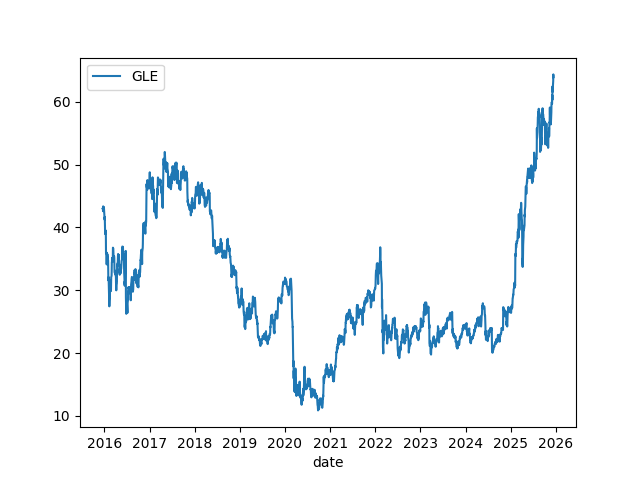

In [80]:
prices[['GLE']].plot()

## Chapter 2: The efficient frontier 

Let's first construct our portfolio P which contains a list of str of the tickers we want in our portfolio. The goal of the code is to get the largest return and the smallest variance. The problem we are facing is an optimization problem which can be written as:

$$
\min \left\{ x^\top \Sigma x \;\middle|\; \mu^\top x = \mu_p,\; l^\top x = 1 \right\}
$$

with l = ( 1, 1, 1.. 1)'


Which is equivalent to :

$$
\max \left\{ \mu^\top x \;\middle|\; x^\top \Sigma x = \sigma_p^2,\; l^\top x = 1 \right\}
$$
or
$$
\begin{aligned}
\max_{x} \quad & \mu^\top x \\
\text{s.c.} \quad & x^\top \Sigma x = \sigma_p^2, \\
& l^\top x = 1
\end{aligned}
$$

and aslo:

$$
\min \left\{ -t\,\mu^\top x + \frac{1}{2} x^\top \Sigma x \;\middle|\; l^\top x = 1 \right\}
$$

or
$$
\begin{aligned}
\min_{x} \quad & -t\,\mu^\top x + \frac{1}{2} x^\top \Sigma x \\
\text{s.c.} \quad & l^\top x = 1
\end{aligned}
$$



Let's now construct all the tool we will need:

In [112]:
sigma = prices.cov()
sigma_np = sigma.to_numpy()
corr = prices.corr()
corr_np = corr.to_numpy()
l = np.array([1 for i in range(len(sigma))])

We are now wondering how to compute/ calculate the vector mu and here comes the theory:

$$ {\mu}$$ is in fact the vector of the expected return for each asset.

In [108]:
sigma

,TTE,AIR,EXA,MC,ORA,GLE,ORCL,BA,COST,NVDA,WMT
TTE,72.517174,201.660183,44.486393,911.862536,-1.018759,15.703905,219.953470,50.626671,1246.259752,222.154013,79.201897
AIR,201.660183,1296.267346,426.336995,5099.897386,-17.547544,59.889233,1604.571638,522.324834,7902.257059,1468.107942,657.858169
EXA,44.486393,426.336995,372.279278,672.046318,4.773071,117.020280,824.491815,-218.723277,3112.101205,744.359130,296.923524
MC,911.862536,5099.897386,672.046318,47423.171659,-348.859634,-971.719725,6356.793216,-3100.217873,41026.952858,5099.790362,2844.622061
ORA,-1.018759,-17.547544,4.773071,-348.859634,4.098092,14.924286,-29.848045,55.325931,-266.787694,-22.290158,-17.537535
GLE,15.703905,59.889233,117.020280,-971.719725,14.924286,123.265254,140.205512,109.042149,-10.446159,148.655119,24.140196
ORCL,219.953470,1604.571638,824.491815,6356.793216,-29.848045,140.205512,2820.030464,-788.786821,12734.867088,2571.521495,1090.659957
BA,50.626671,522.324834,-218.723277,-3100.217873,55.325931,109.042149,-788.786821,5923.403262,-5820.990288,-892.814028,-336.578808
COST,1246.259752,7902.257059,3112.101205,41026.952858,-266.787694,-10.446159,12734.867088,-5820.990288,69907.115683,12246.361745,5527.321264
NVDA,222.154013,1468.107942,744.359130,5099.790362,-22.290158,148.655119,2571.521495,-892.814028,12246.361745,2548.938121,1038.642792


In [113]:
l

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [104]:
corr

,TTE,AIR,EXA,MC,ORA,GLE,ORCL,BA,COST,NVDA,WMT
TTE,1.000000,0.657737,0.270752,0.491715,-0.059096,0.166099,0.486389,0.077246,0.553513,0.516719,0.425934
AIR,0.657737,1.000000,0.613721,0.650457,-0.240757,0.149824,0.839238,0.188498,0.830124,0.807665,0.836781
EXA,0.270752,0.613721,1.000000,0.159945,0.122200,0.546269,0.804683,-0.147291,0.610040,0.764132,0.704753
MC,0.491715,0.650457,0.159945,1.000000,-0.791343,-0.401907,0.549688,-0.184974,0.712547,0.463850,0.598213
ORA,-0.059096,-0.240757,0.122200,-0.791343,1.000000,0.664022,-0.277650,0.355101,-0.498442,-0.218093,-0.396739
GLE,0.166099,0.149824,0.546269,-0.401907,0.664022,1.000000,0.237803,0.127611,-0.003559,0.265204,0.099574
ORCL,0.486389,0.839238,0.804683,0.549688,-0.277650,0.237803,1.000000,-0.192995,0.906999,0.959144,0.940566
BA,0.077246,0.188498,-0.147291,-0.184974,0.355101,0.127611,-0.192995,1.000000,-0.286056,-0.229771,-0.200276
COST,0.553513,0.830124,0.610040,0.712547,-0.498442,-0.003559,0.906999,-0.286056,1.000000,0.917417,0.957372
NVDA,0.516719,0.807665,0.764132,0.463850,-0.218093,0.265204,0.959144,-0.229771,0.917417,1.000000,0.942135


In [114]:
h0 = (np.linalg.inv(sigma_np) @ l)/(l.T @ np.linalg.inv(sigma_np) @ l)
h1 = np.linalg.inv(sigma_np) @ 

In [1]:
sns.pairplot(sigma)

NameError: name 'sns' is not defined